In [ ]:
"""" 
test plot the merged files of (1) RTOFS surface.now hourly analysis data & 
(2) GFS sfc data (forecast hours: 1-6)
"""
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
from scipy import interpolate
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from convert_dir import vector_dir_to_from
from mystats import bandpass
sys.path.insert(0, path_nhchi+'area-master')
# "area" library is from https://github.com/scisco/area
from area import area

In [5]:
year = '2023'
pathG = '/Users/chi/Documents/projects/sd-ni-wp/check_model/check_GFS/GFS.merge.sfc.20230904-20230922.nc'
pathR = '/Users/chi/Documents/projects/sd-ni-wp/check_model/check_RTOFS/RTOFS.merge.surface.now.20230905-20230922.nc'

dsG = nc.Dataset(pathG)
dsR = nc.Dataset(pathR)
print(dsG)
print('====================')
print(dsR)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for GFS sfc data between 20230904 and 20230922
    subtitle: Only selected variables for are merged here. The data is hourly with ~0.117 deg horizontal resolution.
    dimensions(sizes): time(456), longitude(615), latitude(329)
    variables(dimensions): float64 time(time), float64 LON(latitude, longitude), float64 LAT(latitude, longitude), float64 UFLX_AVE(time, latitude, longitude), float64 VFLX_AVE(time, latitude, longitude)
    groups: 
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for RTOFS surface.now. data between 20230905 and 20230922
    subtitle: Only selected variables for are merged here. The data is hourly with 0.08 deg horizontal resolution.
    dimensions(sizes): time(432), depth(1), longitude(901), latitude(551)
    variables(dimensions): float64 depth(depth), float64 time(time), flo

In [6]:
print(dsR['U_VELOCITY'].shape, dsR['LONGITUDE'].shape)
print(np.nanmin(dsR['U_VELOCITY']),np.nanmax(dsR['U_VELOCITY']))
print('='*30)
print(dsG['UFLX_AVE'].shape, dsG['LON'].shape)
print(np.nanmin(dsG['UFLX_AVE']),np.nanmax(dsG['UFLX_AVE']))

(432, 1, 551, 901) (551, 901)
-3.4128530025482178 1.2676506002282294e+30
(456, 329, 615) (329, 615)
-4.999680995941162 5.723142623901367


[258.046875  258.1640625 258.28125  ]
[258.07995605 258.16003418 258.23999023]
[7.55613367 7.55613367 7.55613367]
[7.57781076 7.57781076 7.57781076]


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_62773/2668320488.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_62773/2668320488.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,2)


Text(0, 0.5, 'ΔLatitude ($^o$)')

<Figure size 432x288 with 0 Axes>

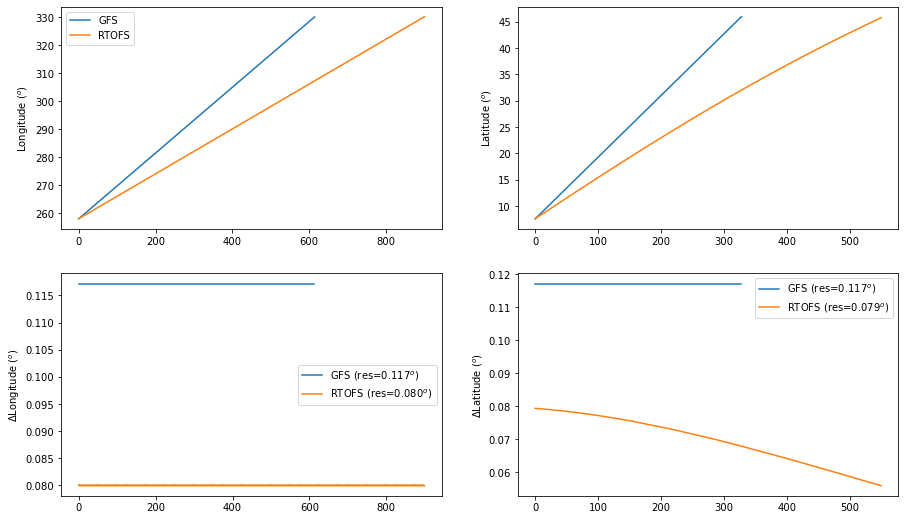

In [7]:
plt.clf()
fig, ax = plt.subplots(1,2, figsize=(15, 9))
plt.subplot(2,2,1)
plt.plot(dsG['LON'][0,:],label='GFS')
plt.plot(dsR['LONGITUDE'][0,:],label='RTOFS')
print(dsG['LON'][0,0:3])
print(dsR['LONGITUDE'][0,0:3])
plt.legend()
plt.ylabel('Longitude ($^o$)')
plt.subplot(2,2,2)
plt.plot(dsG['LAT'][:,0])
plt.plot(dsR['LATITUDE'][:,0])
print(dsG['LAT'][0,0:3])
print(dsR['LATITUDE'][0,0:3])
plt.ylabel('Latitude ($^o$)')
plt.subplot(2,2,3)
plt.plot(np.diff(dsG['LON'][0,:]),label='GFS (res={:.3f}$^o$)'.format(np.diff(dsG['LON'][0,:2])[0]))
plt.plot(np.diff(dsR['LONGITUDE'][0,:]),label='RTOFS (res={:.3f}$^o$)'.format(np.diff(dsR['LONGITUDE'][0,:2])[0]))
plt.legend()
plt.ylabel('\u0394Longitude ($^o$)')
plt.subplot(2,2,4)
plt.plot(np.diff(dsG['LAT'][:,0]),label='GFS (res={:.3f}$^o$)'.format(np.diff(dsG['LAT'][:2,0])[0]))
plt.plot(np.diff(dsR['LATITUDE'][:,0]),label='RTOFS (res={:.3f}$^o$)'.format(np.diff(dsR['LATITUDE'][:2,0])[0]))
plt.legend()
plt.ylabel('\u0394Latitude ($^o$)')

In [8]:
''' Read RTOFS data '''
## read data & set limits of the box
LON_R = dsR['LONGITUDE'][:]
LON_R[LON_R> 180] = LON_R[LON_R> 180]-360
LAT_R = dsR['LATITUDE'][:]
U_R = np.squeeze( dsR['U_VELOCITY'][:] )
V_R = np.squeeze( dsR['V_VELOCITY'][:] )
U_R[U_R> 1e3] = np.nan
V_R[V_R> 1e3] = np.nan
dtime_R = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=dt) \
                  for dt in dsR['time'][:]])
print('shape of LON_R, LAT_R, V_R:',LON_R.shape, LAT_R.shape, V_R.shape)

shape of LON_R, LAT_R, V_R: (551, 901) (551, 901) (432, 551, 901)


lengths of ilat, ilon: 34 31


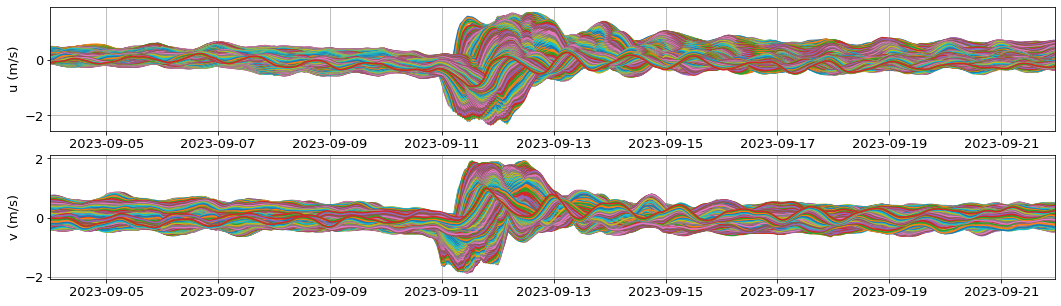

In [9]:
''' Give a lon/ lat limits and plot time series of u/v
'''
lonlim = np.array([-65, -62.5])
latlim = np.array([22.5, 25])
### 
ilon = np.where( (LON_R[0,:]>= lonlim[0]) & (LON_R[0,:]< lonlim[1]) )[0]
ilat = np.where( (LAT_R[:,0]>= latlim[0]) & (LAT_R[:,0]< latlim[1]) )[0]
print('lengths of ilat, ilon:',len(ilat),len(ilon))
### go through each selected grid
plt.clf()
plt.gcf().set_size_inches(18, 5)
plt.rcParams.update({'font.size': 13})
for i in ilat:
    for j in ilon:
        u_this = np.squeeze( U_R[:,i,j] )
        v_this = np.squeeze( V_R[:,i,j] )
        plt.subplot(2,1,1)
        plt.plot(dtime_R, u_this)
        plt.subplot(2,1,2)
        plt.plot(dtime_R, v_this)

for i in range(2):
    plt.subplot(2,1,i+1)
    plt.xlim([np.min(dtime_R),np.max(dtime_R)])
    plt.grid()
    if i == 0:
        plt.ylabel('u (m/s)')
    if i == 1:
        plt.ylabel('v (m/s)')
### save figure
plt.savefig('timeseries_uv(RTOFS.merge.surface.now.20230905-20230922)_{:.2f}-{:.2f}N_{:.2f}-{:.2f}'\
            .format(latlim[0],latlim[1],lonlim[0],lonlim[1])+'.png',dpi=400,bbox_inches='tight')

Coriolis frequency of latlim: [5.56590491e-05 6.14673346e-05]
Band pass frequency: [5.00931442e-05 6.76140680e-05]


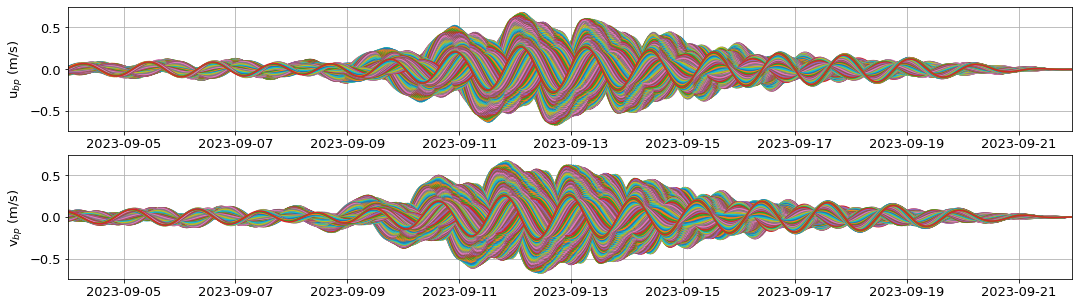

In [10]:
''' Give a frequency limit to filter timeseries to NI band (try 0.9xf(22.5N) to 1.1xf(25N))
'''
f_latlim = 2*(2*np.pi/86400)*np.sin(latlim/180*np.pi) # 1/s
print('Coriolis frequency of latlim:',f_latlim)
f_bp = np.array([0.9*np.min(f_latlim), 1.1*np.max(f_latlim)])
print('Band pass frequency:',f_bp)
u_bp = np.nan*np.ones( (len(dtime_R),len(ilat),len(ilon)) )
v_bp = u_bp.copy()
bp_sec = 2*np.pi/f_bp
dsec_RTOFS = (dtime_R[1]-dtime_R[0]).total_seconds()
### go through each selected grid
plt.clf()
plt.gcf().set_size_inches(18, 5)
plt.rcParams.update({'font.size': 13})
for icnt, i in enumerate(ilat):
    for jcnt, j in enumerate(ilon):
        u_bp[:,icnt,jcnt],_,_,_,_ = bandpass( np.squeeze( U_R[:,i,j] ), dsec_RTOFS,bp_sec[0],bp_sec[1],2 )
        v_bp[:,icnt,jcnt],_,_,_,_ = bandpass( np.squeeze( V_R[:,i,j] ), dsec_RTOFS,bp_sec[0],bp_sec[1],2 )
        plt.subplot(2,1,1)
        plt.plot(dtime_R, u_bp[:,icnt,jcnt])
        plt.subplot(2,1,2)
        plt.plot(dtime_R, v_bp[:,icnt,jcnt])
for i in range(2):
    plt.subplot(2,1,i+1)
    plt.xlim([np.min(dtime_R),np.max(dtime_R)])
    plt.grid()
    if i == 0:
        plt.ylabel('u$_{bp}$ (m/s)')
    if i == 1:
        plt.ylabel('v$_{bp}$ (m/s)')
### save figure
plt.savefig('timeseries_uv-bp(RTOFS.merge.surface.now.20230905-20230922)_{:.2f}-{:.2f}N_{:.2f}-{:.2f}'\
            .format(latlim[0],latlim[1],lonlim[0],lonlim[1])+'.png',dpi=400,bbox_inches='tight')        

In [11]:
''' Read GFS data '''
## read data & set limits of the box
LON_G = dsG['LON'][:]
LON_G[LON_G> 180] = LON_G[LON_G> 180]-360
LAT_G = dsG['LAT'][:]
UFLX_AVE = np.squeeze( dsG['UFLX_AVE'][:] )
VFLX_AVE = np.squeeze( dsG['VFLX_AVE'][:] )
UFLX_AVE[UFLX_AVE> 1e3] = np.nan
VFLX_AVE[VFLX_AVE> 1e3] = np.nan
dtime_G = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=dt) \
                  for dt in dsG['time'][:]])
print('shape of LON_G, LAT_G, VFLX_AVE:',LON_G.shape, LAT_G.shape, VFLX_AVE.shape)

shape of LON_G, LAT_G, VFLX_AVE: (329, 615) (329, 615) (456, 329, 615)


In [12]:
''' Interpolate surface zonal momentum flux to RTOFS spatial grids '''
x_G = LON_G[0,:][:]
y_G = LAT_G[:,0][:]
ilon = np.where( (LON_R[0,:]>= lonlim[0]) & (LON_R[0,:]< lonlim[1]) )[0]
ilat = np.where( (LAT_R[:,0]>= latlim[0]) & (LAT_R[:,0]< latlim[1]) )[0]
x_R = LON_R[0,ilon][:]
y_R = LAT_R[ilat,0][:]
UFLX_AVE_onR = np.nan*np.ones( (len(dtime_R),len(y_R),len(x_R)) )
VFLX_AVE_onR = UFLX_AVE_onR.copy()
for t in range( len(dtime_R) ):
    it_G = np.where( dtime_G == dtime_R[t] )[0]
    if len(it_G) == 1:
        f_U = interpolate.interp2d(x_G,y_G,np.squeeze(UFLX_AVE[t,:,:]))
        # print(dtime_G[it_G], dtime_R[t])
        f_V = interpolate.interp2d(x_G,y_G,np.squeeze(VFLX_AVE[t,:,:]))
        for i, lat in enumerate( y_R ):
            for j, lon in enumerate( x_R ):
                UFLX_AVE_onR[t,i,j] = f_U(lon, lat)
                VFLX_AVE_onR[t,i,j] = f_V(lon, lat)
        # plt.pcolormesh(x_R, y_R, VFLX_AVE_onR[t,:,:])
        # plt.colorbar()

/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_62773/296500905.py:13: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f_U = interpolate.interp2d(x_G,y_G,np.squeeze(UFLX_AVE[t,:,:]))
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_62773/296500905.py:15: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` f

In [ ]:
''' Compute wind power input (RTOFS spatial grids)'''
tlim_wp = [np.max([dtime_G[0],dtime_R[0]]), np.min([dtime_G[-1],dtime_R[-1]])]
print(tlim_wp)
it_G = np.where( (dtime_G>= tlim_wp[0]) & (dtime_G<= tlim_wp[1]) )[0]
it_R = np.where( (dtime_R>= tlim_wp[0]) & (dtime_R<= tlim_wp[1]) )[0]
print('GFS ({:.1f}) time limits'.format(len(dtime_G[it_G])),dtime_G[it_G][0],dtime_G[it_G][-1])
print('RTOFS ({:.1f}) time limits'.format(len(dtime_R[it_R])),dtime_R[it_R][0],dtime_R[it_R][-1])
print(UFLX_AVE_onR[it_G,:,:].shape, u_bp.shape)
timestamp_wp = np.array([ dtime_R[it_R][i].timestamp() for i in range( len(it_R) ) ])
''' compute wind power'''
wp = np.multiply( -UFLX_AVE_onR[it_G,:,:],u_bp[it_R,:,:] ) + \
    np.multiply( -VFLX_AVE_onR[it_G,:,:],v_bp[it_R,:,:] )
''' mean wind power of the box (for each time)'''
wp_mn_box = np.nanmean( np.nanmean(wp,axis=2), axis=1 )
wp_mn_box[0] = 0
''' energy intput integrated over time '''
energy_wp = np.zeros( (len(timestamp_wp),) )
for t in range( len(timestamp_wp) ):
    energy_wp[t] = np.trapz( wp_mn_box[:t+1],timestamp_wp[:t+1] )

[datetime.datetime(2023, 9, 4, 1, 0), datetime.datetime(2023, 9, 21, 23, 0)]
GFS (431.0) time limits 2023-09-04 01:00:00 2023-09-21 23:00:00
RTOFS (431.0) time limits 2023-09-04 01:00:00 2023-09-21 23:00:00
(431, 34, 31) (432, 34, 31)


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_62773/436432232.py:12: RuntimeWarning: Mean of empty slice
  wp_mn_box = np.nanmean( np.nanmean(wp,axis=2), axis=1 )


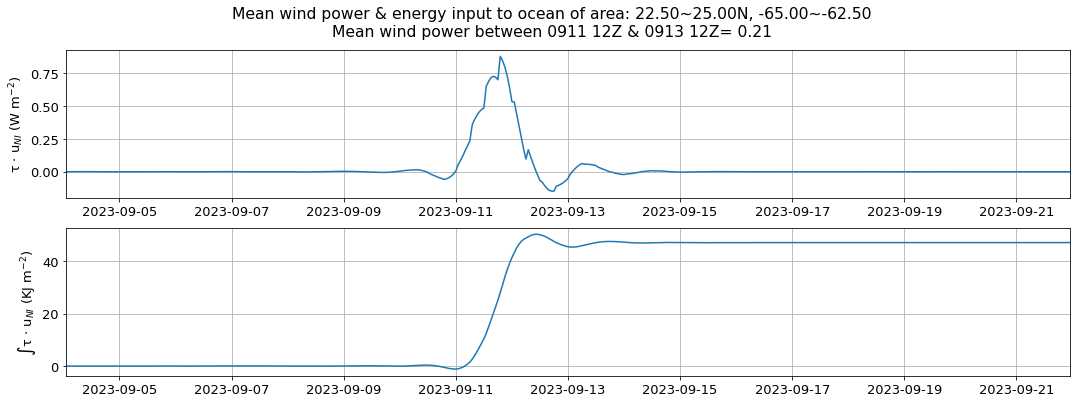

In [67]:
''' plot timeseries of wind power and energy input of this event '''
tlim_4_mn = [datetime.datetime(int(year),9,11,12),datetime.datetime(int(year),9,13,12)]
it_4_mn = np.where( (dtime_R[it_R]>= tlim_4_mn[0]) & (dtime_R[it_R]<= tlim_4_mn[1]) )[0]
plt.clf()
plt.gcf().set_size_inches(18, 6)
plt.rcParams.update({'font.size': 13})
''' wind power'''
plt.subplot(2,1,1)
plt.plot(dtime_R[it_R],wp_mn_box)
plt.xlim(tlim_wp)
plt.grid()
plt.ylabel('\u03C4 $\cdot$ u$_{NI}$ (W m$^{-2}$)')
''' energy input'''
plt.subplot(2,1,2)
plt.plot(dtime_R[it_R],energy_wp*1e-3)
plt.xlim(tlim_wp)
plt.grid()
plt.ylabel('$\int$\u03C4 $\cdot$ u$_{NI}$ (KJ m$^{-2}$)')
##
plt.suptitle('Mean wind power & energy input to ocean of area: {:.2f}~{:.2f}N, {:.2f}~{:.2f}'\
             .format(latlim[0],latlim[1],lonlim[0],lonlim[1])+'\n'+\
                'Mean wind power between '+tlim_4_mn[0].strftime('%m%d %HZ')+' & '+\
                    tlim_4_mn[1].strftime('%m%d %HZ')+\
                        '= {:.2f}'.format(np.nanmean(wp_mn_box[it_4_mn])))
### save figure
plt.savefig('mean_wp_energy_of_area({:.2f}-{:.2f}N_{:.2f}-{:.2f})_'\
            .format(latlim[0],latlim[1],lonlim[0],lonlim[1])+\
                tlim_wp[0].strftime('%Y%m%d')+'-'+tlim_wp[1].strftime('%Y%m%d')+\
                    '.png',dpi=400,bbox_inches='tight')

In [57]:
### Following 
# https://stackoverflow.com/questions/4681737/how-to-calculate-the-area-of-a-polygon-on-the-earths-surface-using-python
print(lonlim)
print(latlim)
obj = {'type':'Polygon','coordinates':[[[lonlim[0],latlim[0]],[lonlim[0],latlim[1]],\
                                        [lonlim[1],latlim[1]],[lonlim[1],latlim[0]],[lonlim[0],latlim[0]]]]}
area_m2 = area(obj)
print('The total area of the box is {:.1f} m^2 = {:.1f} km^2'.format(area_m2,area_m2*1e-6))
test = 0.21*area_m2
print('This box input {:.3f} TW of power'.format(test*1e-12))

[-65.  -62.5]
[22.5 25. ]
The total area of the box is 70885416660.5 m^2 = 70885.4 km^2
This box input 0.015 TW of power


In [58]:
### load topography data
path_topo = '/Users/chi/Documents/Data/Topography/GEBCO_16_Jan_2025/'
ds_topo = nc.Dataset(path_topo+'gebco_2024_n35.0_s-5.0_w-92.0_e-40.0.nc')
# print(ds_topo)
lon_topo = ds_topo.variables['lon'][:]
lat_topo = ds_topo.variables['lat'][:]
elevation = ds_topo.variables['elevation'][:]
print(lon_topo.shape, lat_topo.shape, elevation.shape )
ilon = np.where( (lon_topo>= lonlim[0]) & (lon_topo<= lonlim[1]) )[0]
ilat = np.where( (lat_topo>= latlim[0]) & (lat_topo<= latlim[1]) )[0]
print(lon_topo[ilon].shape, lat_topo[ilat].shape, elevation[np.ix_(ilat,ilon)].shape )

(12480,) (9600,) (9600, 12480)
(600,) (600,) (600, 600)


<Figure size 432x288 with 0 Axes>

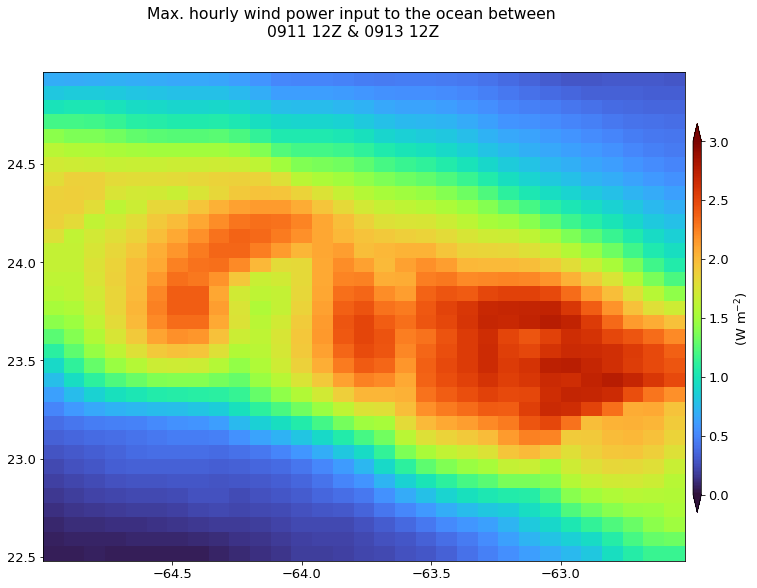

In [75]:
''' Plot the max wind power over this period on map '''
max_wp = np.nan*np.ones( (wp.shape[1],wp.shape[2]) )
for i in range( wp.shape[1] ):
    for j in range( wp.shape[2] ):
        max_wp[i,j] = np.nanmax( wp[:,i,j] )
''' plot max wp over this period of time '''
plt.clf()
fig, ax = plt.subplots(1)
plt.gcf().set_size_inches(11.5, 9)
plt.rcParams.update({'font.size': 13})
cs = plt.pcolormesh(x_R, y_R, max_wp, cmap='turbo',vmin=0,vmax=3)
# plt.contour(lon_topo[ilon], lat_topo[ilat], elevation[np.ix_(ilat,ilon)],colors='k',levels=0)
### add colorbar
cbar_ax = fig.add_axes([.91,.2,.01,.6])
axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
axf.set_label('(W m$^{-2}$)', rotation=90)
plt.suptitle('Max. hourly wind power input to the ocean between \n'+
             tlim_4_mn[0].strftime('%m%d %HZ')+' & '+tlim_4_mn[1].strftime('%m%d %HZ'))
### save figure
plt.savefig('max_wp_onMap({:.2f}-{:.2f}N_{:.2f}-{:.2f})_'\
            .format(latlim[0],latlim[1],lonlim[0],lonlim[1])+\
                tlim_4_mn[0].strftime('%Y%m%d%HZ')+'-'+tlim_4_mn[1].strftime('%m%d%HZ')+\
                    '.png',dpi=400,bbox_inches='tight')